In [6]:
from PIL import Image, ImageOps
import numpy as np
from einops import rearrange
from diffusers.utils import make_image_grid
from src.utils.mask_v2 import Maskerv2
from src.utils import random_dilate_mask

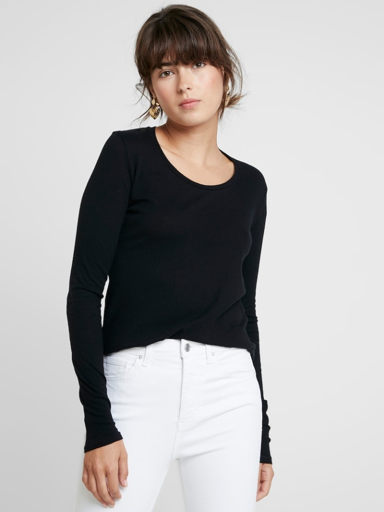

In [2]:
# h, w = (384, 192)
# h, w = (1024, 768)
h, w = (512, 384)
# h, w = (800, 600)
BASE_DATA_PATH= '../datasets/vitonhd' # You need to point your data root path here.
CATEGORY = 'upper_body'
img = Image.open(f'{BASE_DATA_PATH}/test/image/00006_00.jpg')
# img = Image.open('../assets/red_dress_girl.jpg')
img = ImageOps.fit(img, size=(w, h))
img

/home/hosjiu/workspace/heatmob/vto-engine/src/preprocess/openpose/annotator/openpose/body.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(sel

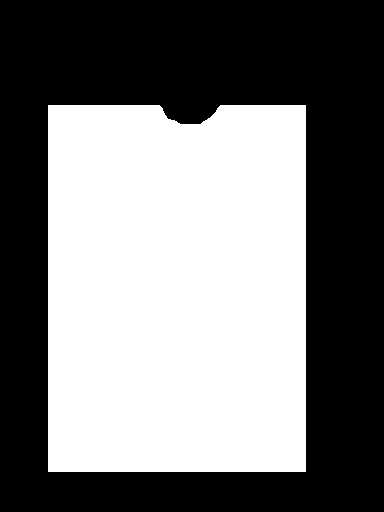

In [3]:
masker = Maskerv2()
mask, body_parse = masker.create_mask(img, category='upper_body', return_body_parse=True)
mask

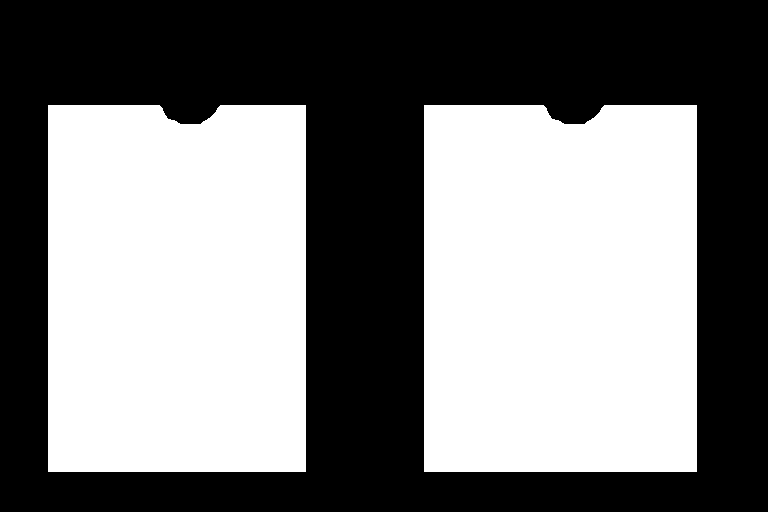

In [110]:
make_image_grid([mask, random_dilate_mask(mask)], 1, 2)

In [630]:
np.unique(np.array(mask))

array([  0, 255], dtype=uint8)

### Random dilated mask

In [631]:
import cv2
import cv2 as cv
import numpy as np

mask_arr = np.array(mask)
iterations=1
mask_arr = cv2.erode(mask_arr, np.ones((3, 3), np.uint8), iterations=iterations)
contours, _ = cv2.findContours(mask_arr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours

(array([[[ 49, 106]],
 
        [[ 49, 470]],
 
        [[304, 470]],
 
        [[304, 106]],
 
        [[221, 106]],
 
        [[218, 109]],
 
        [[218, 110]],
 
        [[217, 111]],
 
        [[217, 112]],
 
        [[210, 119]],
 
        [[209, 119]],
 
        [[207, 121]],
 
        [[206, 121]],
 
        [[205, 122]],
 
        [[204, 122]],
 
        [[201, 125]],
 
        [[179, 125]],
 
        [[178, 124]],
 
        [[177, 124]],
 
        [[175, 122]],
 
        [[174, 122]],
 
        [[173, 121]],
 
        [[170, 121]],
 
        [[169, 120]],
 
        [[167, 120]],
 
        [[165, 118]],
 
        [[165, 117]],
 
        [[163, 115]],
 
        [[163, 114]],
 
        [[162, 113]],
 
        [[162, 112]],
 
        [[161, 111]],
 
        [[161, 109]],
 
        [[158, 106]]], dtype=int32),)

In [632]:
contours = sorted(list(contours), key=lambda x: x.shape[0], reverse=True)
contours[0].shape

(34, 1, 2)

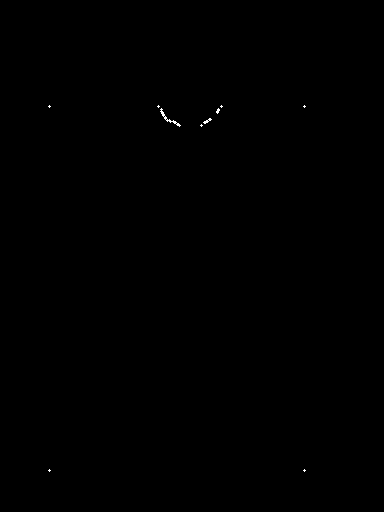

In [633]:
hull = cv2.convexHull(contours[0])
contour_arr = cv2.drawContours(np.zeros_like(mask), contours[0], -1, (255, 0, 0), 2)
Image.fromarray(contour_arr)

In [634]:
hull = np.squeeze(hull)
hull

array([[304, 106],
       [304, 470],
       [ 49, 470],
       [ 49, 106]], dtype=int32)

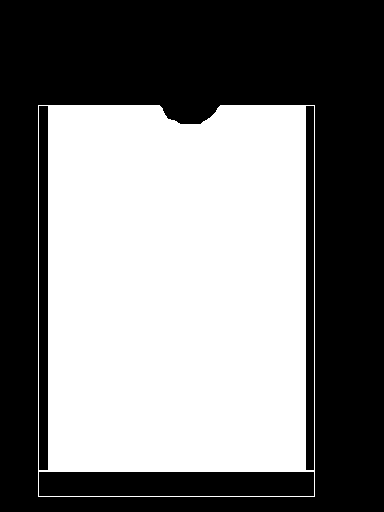

In [915]:
""" Main Implementation """
import random

delta_x = random.uniform(0.001, 0.1)
delta_y = random.uniform(0.001, 0.3)
mask_width = hull[0][0] - hull[3][0]
mask_height = hull[1][1] - hull[0][1]
new_x_left = int(hull[3][0] - delta_x * mask_width)
new_x_right = int(hull[0][0] + delta_x * mask_width)
new_y = int(hull[1][1] + delta_y * mask_height)

new_x_left = max(0, new_x_left)
new_x_right = min(new_x_right, mask.size[0])
new_y = min(new_y, mask.size[1])

new_mask = cv.rectangle(
    np.array(mask),
    (new_x_left, hull[3][1] - iterations),
    (hull[2][0], hull[2][1] + iterations),
    (255, 255, 255),
    1
)
new_mask = cv.rectangle(
    new_mask,
    (hull[0][0], hull[0][1] - iterations),
    (new_x_right, hull[1][1] + iterations),
    (255, 255, 255),
    1
)
new_mask = cv.rectangle(new_mask, (new_x_left, hull[2][1]), (new_x_right, new_y), (255, 255, 255), 1)

Image.fromarray(new_mask)

In [848]:
random.uniform(0.001, 0.1)

0.02396280853431076

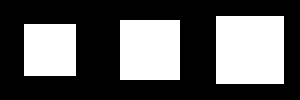

In [636]:
import cv2
import numpy as np
from diffusers.utils import make_image_grid

# Create a simple binary image (white square on black background)
image = np.zeros((100, 100), np.uint8)
image[30:70, 30:70] = 255

# Define a kernel (structuring element)
kernel = np.ones((5, 5), np.uint8)

# Dilate the image with different iterations
dilated_1 = cv2.dilate(image, kernel, iterations=3)
dilated_2 = cv2.dilate(image, kernel, iterations=5)
dilated_3 = cv2.dilate(image, kernel, iterations=7)

make_image_grid(list(map(Image.fromarray, [dilated_1, dilated_2, dilated_3])), 1, 3)

# Display the results (you'll need a way to display images, e.g., using matplotlib)
# ...

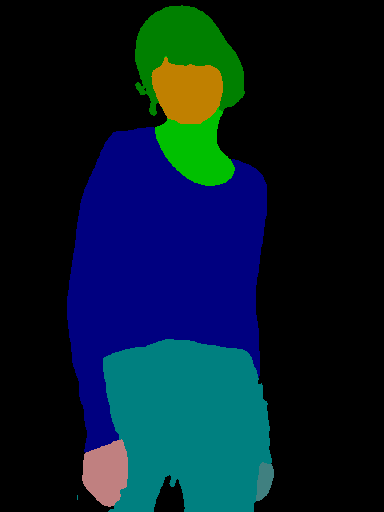

In [637]:
body_parse

In [638]:
13 in np.array(body_parse)

False

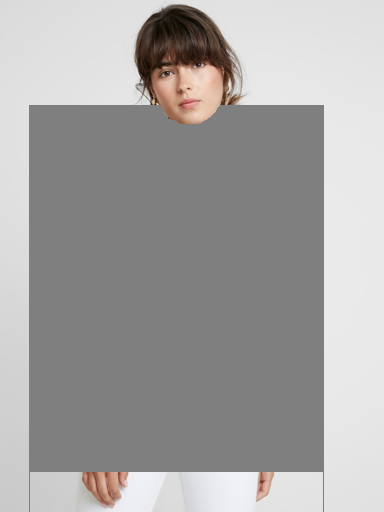

In [639]:
mask_np = np.array(new_mask)
mask_np = np.stack([mask_np] * 3)
mask_np = rearrange(mask_np, 'c h w -> h w c')
img_np = np.array(img)
out = np.where(mask_np, np.ones_like(mask_np) * 127, img_np)
Image.fromarray(out)

In [640]:
# mask = Image.open('../datasets/vitonhd/train/agnostic-mask-v2/00113_00.jpg')

# mask_np = np.array(mask)
# mask_np = np.stack([mask_np] * 3)
# mask_np = rearrange(mask_np, 'c h w -> h w c')
# img_np = np.array(img)
# masked_img_np = np.where(mask_np, np.ones_like(mask_np) * 127, img_np)
# Image.fromarray(masked_img_np)

In [641]:
from diffusers.utils import make_image_grid

make_image_grid([mask, Image.fromarray(out), img], 1, 3).save('/mnt/f/hosjiu/test.jpg')